## Introduction



### Dataset Overview
The original dataset, sourced from Kaggle, contains customer data from a retail company, with 2240 observations and 29 variables. Each row represents a unique customer.

The data spans four main dimensions:

1. **Demographics**: Includes customer birth year, education level, marital satus, household composition, income, and date of enrollment.
2. **Purchase Behavior**: Captures total spending over the past two years across six product categories - wine, fruits, meat, fish, sweets, and gold.
3. **Promotional Response**: Tracks participation in five historical marketing campaigns and one recent campaign, along with discount-based purchase counts.
4. **Shopping Channel Use**: Records purchasing frequency across website, store, and catalog, as well as recent website visits.


### Analysis Objective
The objective of this analysis is to identify distinct customer segments based on demographic and behavioral using **PCA** and **clustering analysis**. We aim to uncover underlying customer personas that can help the company better target marketing efforts, personalize campaigns, and optimize resource allocaion. These insights can support more effective segmentation strategies and enhance customer engagement.

## Analysis

### Importing packages and data

In [ ]:
import pandas as pd
import numpy as np
from io import StringIO # for reading url csv transfer into a doc
import requests # also for request HTTP read.csv

import matplotlib.pyplot as plt # import deafault plotting pacakage
import seaborn as sns # for statistical data visualization
sns.set()

# use scikit-learn library that contains many different machine learning methods to call PCA and KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [ ]:
url = "https://raw.githubusercontent.com/Leooonado/dataset/refs/heads/main/marketing_campaign.csv"
response = requests.get(url)
data_raw = StringIO(response.text)
data = pd.read_csv(data_raw, sep = '\t')
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Data cleaning

In [ ]:
data.info() # Information on features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

> After reviewing the dataset, we found 24 missing values in the Income variable. For ease of analysis, we removed the rows containing these missing values.

In [ ]:
data = data.dropna() # Remove the NA values
print("Number of datapoints after removing NA values:", len(data))

Number of datapoints after removing NA values: 2216


### Data Transformation & Feature Engineering

To prepare the dataset for Principal Component Analysis (PCA), we performed several transformation and feature engineering steps to derive more meaningful and informative variables, while also simplifying or removing redundant ones.
- **Tenure Calculation:** We converted the `Dt_Customer` column into a datetime format and created a new feature Tenure_Days, representing the number of days since the customer enrolled, relative to the most recent customer in the dataset.

- **Age:** We derived the current age of each customer using the year of birth.
    - **Special Note:** To maintain internal consistency with the dataset's original snapshot and to align the definition of Tenure with Recency, we computed Tenure_Days relative to the latest recorded customer entry (Dt_Customer.max()). Although age was computed as of 2025, this difference reflects the fact that age is an absolute demographic measure, while tenure and recency are relative to the firm’s observation window."

- **Simplified Education Levels:** To reduce the complexity of the `Education` variable, we consolidated five original levels into three categories: Undergraduate, Graduate, and Postgraduate. Then we applied label encoding.

- **Living Situation:** We created a new feature `Living_With` to simplify the marital status into two categories: Alone and Partner. This was then label encoded for modeling.

- **Family Composition:** We engineered three features related to household structure:
    - `Children`: Sum of kids and teens.
    - `Family_Size`: Total number of people in the household.
    - `Is_Parent`: Binary flag for whether the customer has children.

- **Total Spending:** We aggregated spending across six product categories to form a single measure Spent, representing the total customer value.

- **Drop Unnecessary Columns:** Finally, we dropped columns that were either IDs, redundant, or not needed for clustering.

In [ ]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True) # Convert to datetime

data["Tenure_Days"] = (data["Dt_Customer"].max() - data["Dt_Customer"]).dt.days # Create a new feature: the number of days since the customer (enrolled) started to shop from this company relative to the last recorded date

data["Age"] = 2025 - data["Year_Birth"] # Age of customers today

data["Education"] = data["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"}) # Decrease education levels to 3
edu_map = {"Undergraduate": 0, "Graduate": 1, "Postgraduate": 2} # Label encoding for Education
data["Education"] = data["Education"].map(edu_map)

data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",}) # Derive living situation by marital status "Alone"
living_map = {"Alone": 0, "Partner": 1} # Label encoding for Living_With
data["Living_With"] = data["Living_With"].map(living_map)

data["Children"]  = data["Kidhome"] + data["Teenhome"] # Feature for total number of children in the family
data["Family_Size"] = data["Children"] + data["Living_With"].replace({"Alone":1, "Partner":2}) # Feature for total members in the family: Family size = number of kids + partner
data["Is_Parent"] = np.where(data.Children > 0, 1, 0) # Feature pertaining parenthood
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"] # Total spendings on various items

to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data=data.drop(to_drop, axis=1) # Drop the columns that are not needed

To better understand the distribution and potential anomalies in the dataset, we examined summary statistics and visualized the distributions of key numeric variables using boxplots. This step helped us identify extreme values that may distort distance-based methods like PCA.

In [ ]:
data.describe() # The stats show some discrepancies in mean Income and Age, and max Income and Age

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp2,Complain,Response,Tenure_Days,Age,Living_With,Children,Family_Size,Is_Parent,Spent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,1.267148,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,...,0.013538,0.009477,0.150271,353.521209,56.179603,0.645307,0.947202,1.592509,0.714350,607.075361
std,0.652084,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,...,0.115588,0.096907,0.357417,202.434667,11.985554,0.478528,0.749062,0.905722,0.451825,602.900476
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,1.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,180.000000,48.000000,0.000000,0.000000,1.000000,0.000000,69.000000
50%,1.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,...,0.000000,0.000000,0.000000,355.500000,55.000000,1.000000,1.000000,2.000000,1.000000,396.500000
75%,2.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,...,0.000000,0.000000,0.000000,529.000000,66.000000,1.000000,1.000000,2.000000,1.000000,1048.000000
max,2.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,...,1.000000,1.000000,1.000000,699.000000,132.000000,1.000000,3.000000,4.000000,1.000000,2525.000000


We used seaborn boxplots to visually detect the presence of outliers in these variables:

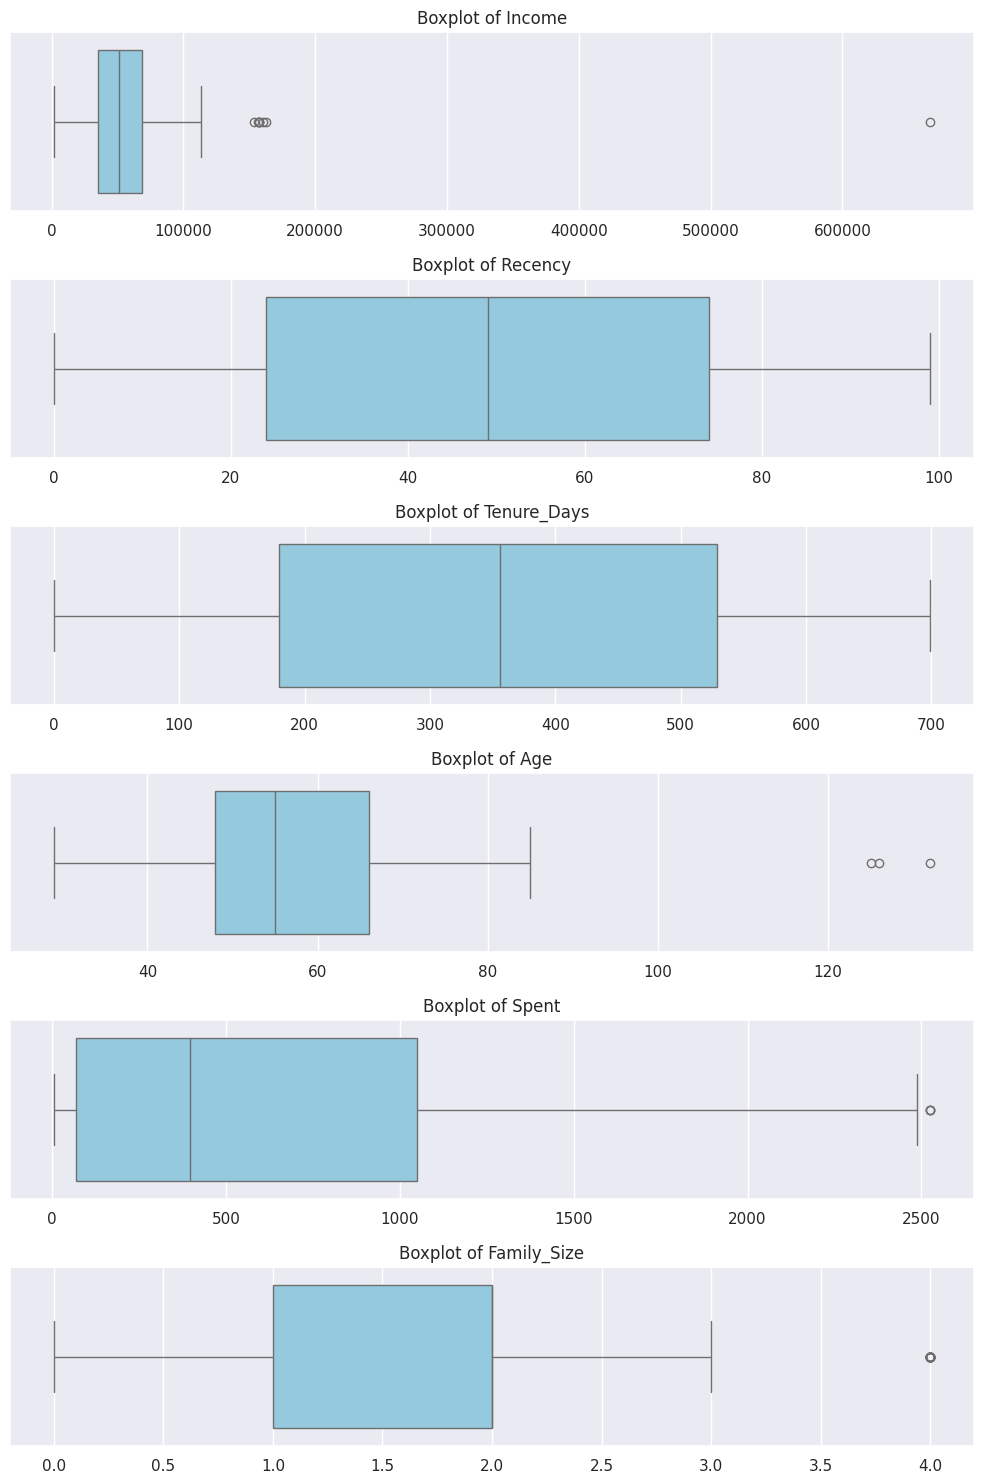

In [ ]:
# Plot the boxplots for the selected vraiables
selected_vars = ["Income", "Recency", "Tenure_Days", "Age", "Spent","Family_Size"]
num_vars = len(selected_vars)
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(10, 2.5 * num_vars))

# Plot each boxplot on its own axis
for i, var in enumerate(selected_vars):
    sns.boxplot(x=data[var], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot of {var}", fontsize=12)
    axes[i].set_xlabel("")  # Remove x-axis label for clean look

plt.tight_layout()
plt.show()

These visualizations revealed significant outliers in variables like `Income` and `Age`, which can disproportionately influence PCA and clustering results.

Given the sensitivity of PCA to extreme values, we removed outliers in two critical variables — `Income` and `Age` — by applying upper bounds:

- `Income`: Capped at $600,000 (removes an unrealistic outlier at 666,666)

- `Age`: Capped at 90 years (removes biologically implausible values)

In [ ]:
data = data[(data["Age"] < 90)] # Drop the outliers by setting a cap on Age and Income
data = data[(data["Income"] < 600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


We now prepare the data for input into the PCA. The following modifications are applied:
1. The campaign response variables (e.g., **`AcceptedCmp1`** - **`AcceptedCmp5`**), as well as **`Complain`** will be excluded from the PCA input. Because these variables reflect specific customer interactions with past marketing campaigns and complaints, which may be outcomes of latent customer traits rather than core descriptors.

2. In a real-world project, we would follow up by analyzing how different customer segments respond to campaigns, but that is beyond the scope of this analysis.

3. The dataset **`df_s`** fed into PCA is centered and standardized to ensure that all variables contribute equally to the analysis, regardless of their original scales.

In [ ]:
df = data.copy() # Create a copy of data
cols_del = ["AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "AcceptedCmp1", "AcceptedCmp2", "Complain", "Response"] # Create a subset dataframe by dropping some features for dimensionality reduction
df = df.drop(cols_del, axis = 1)
df_s = (df - df.mean()) / df.std() # Standardize the data
df_s.describe().round(2).loc[['mean', 'std']]

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Tenure_Days,Age,Living_With,Children,Family_Size,Is_Parent,Spent
mean,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Dimensionality Reduction

To reduce the dimensionality of our dataset and identify the key underlying components that explain customer behavior, we applied Principal Component Analysis (PCA) to the standardized dataset.

We begin by creating a PCA object and fitting it to the standardized data **`df_s`**. The `fit` method calculates the principal component directions (also called eigenvectors), and the `transform` method generates the principal component scores for each observation in the new reduced space.

In [ ]:
pca = PCA()
pca.fit(df_s) # Fit the PCA model

pca_directions = pd.DataFrame(
    pca.components_.T,
    index=df.columns,
    columns=['PC' + str(l + 1) for l in range(pca.n_components_)],
)

pca_scores = pd.DataFrame(
    pca.transform(df_s),
    columns = ['PC' + str(l + 1) for l in range(pca.n_components_)],
)

To determine the optimal number of components to retain, we generated a summary table and scree plot.
> The scree plot revealed an elbow after the third component, suggesting that a 3-component solution offers a good balance between interpretability and explained variance, capturing approximately 56% of the total variance.


In [ ]:
explained_variance = pd.DataFrame({
    'PC': ['PC'+str(i+1) for i in range(len(pca.explained_variance_))],
    'Eigenvalue': pca.explained_variance_.round(3),
    'Explained_Variance_Ratio': pca.explained_variance_ratio_.round(3),
    'Cumulative': np.cumsum(pca.explained_variance_ratio_)
})
explained_variance

,PC,Eigenvalue,Explained_Variance_Ratio,Cumulative
0,PC1,8.278,0.360,0.359919
1,PC2,2.949,0.128,0.488118
2,PC3,1.577,0.069,0.556674
3,PC4,1.398,0.061,0.617462
4,PC5,1.093,0.048,0.664982
5,PC6,1.006,0.044,0.708739
6,PC7,0.989,0.043,0.751746
7,PC8,0.778,0.034,0.785553
8,PC9,0.658,0.029,0.814155
9,PC10,0.643,0.028,0.842106


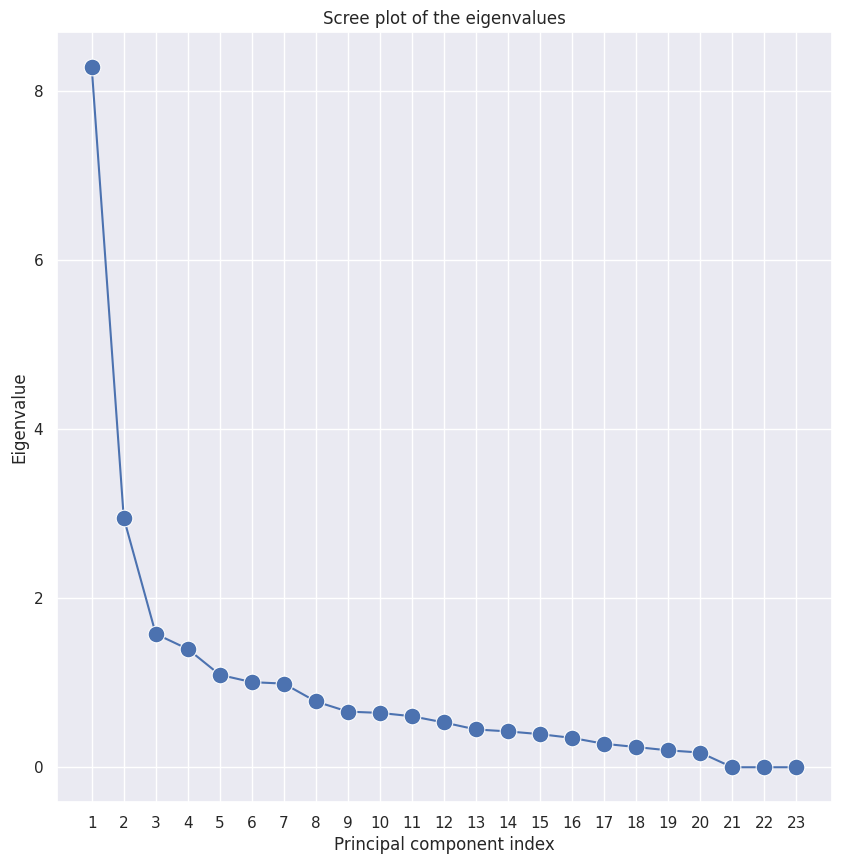

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Scree plot of the eigenvalues')
plt.xlabel('Principal component index')
plt.ylabel('Eigenvalue')

sns.lineplot(
    x=np.arange(len(pca_scores.var())) + 1,
    y=pca_scores.var(),
    marker='o',
    markersize=12,
)
plt.xticks(np.arange(len(pca_scores.var())) + 1)
plt.show()

### 3-Component PCA

Based on the scree plot recommendation, we proceed with a PCA using 3 components.

In [ ]:
pca_3 = PCA(n_components = 3) # Choose the 3 components pca
pca_3.fit(df_s) # Fit the PCA model

pca_3_directions = pd.DataFrame(
    pca_3.components_.T,
    index=df.columns,
    columns=['PC' + str(l + 1) for l in range(pca_3.n_components_)],
)

pca_3_scores = pd.DataFrame( # Get PCA directions and scores
    pca_3.transform(df_s),
    columns = ['PC' + str(l + 1) for l in range(pca_3.n_components_)],
)

> To interpret the contribution of original features to each principal component, we compute the PCA loadings by scaling the directions by the square root of the eigenvalues. This helps us understand what each component represents.

In [ ]:
pca_3_loadings = pca_3_directions * np.sqrt(pca_3.explained_variance_) # Compute loadings
pca_3_loadings.round(2)

,PC1,PC2,PC3
Education,0.03,0.23,-0.45
Income,0.80,0.29,-0.26
Kidhome,-0.71,0.01,0.15
Teenhome,-0.28,0.78,-0.23
Recency,0.01,0.03,0.02
MntWines,0.74,0.36,0.00
MntFruits,0.69,0.02,0.12
MntMeatProducts,0.82,0.02,-0.01
MntFishProducts,0.72,0.00,0.13
MntSweetProducts,0.68,0.04,0.13


**PCA Interpretation**

These loadings allow us to interpret the PCs:

- A customer with a high positive PC1 score may show high levels of spending (Spent), income (Income), and frequent purchases across wine, meat, fruits, and gold product categories — especially via store and catalog channels.
And a negative alignment with family-related variables like Kidhome, Children, Family_Size, and Is_Parent, indicating fewer dependents or single-person households.

- A customer with a high positive PC2 score may suggest strong engagement with online purchasing (NumWebPurchases), promotional deals (NumDealsPurchases), and likely living in larger households with teenagers and children (Teenhome, Children, Is_Parent, Family_Size).
And a negative alignment with niche or lower-impact categories such as purchases of fish, sweets, and gold products (MntFishProducts, MntSweetProducts, MntGoldProds), as well as household structures without children (Kidhome). These customers are not strongly defined by premium or specialty product interests.

- A customer with a high positive PC3 score may demonstrate longer tenure with the company (Tenure_Days), higher website visit frequency (NumWebVisitsMonth), and moderate digital or promotional engagement.
And a negative alignment with older age (Age), higher education (Education), and family-related variables like Teenhome and Children, suggesting this group may skew younger, less formally educated, and more likely to be single or without children — but digitally active and highly engaged with the brand online.

> Below we standardize the PCA scores so that each component has unit variance, making them comparable across clusters.

In [ ]:
pca_3_scores_standardized = pca_3_scores / pca_3_scores.std() # Standardize the PCA scores
pca_3_scores_standardized

,PC1,PC2,PC3
0,1.722893,-0.175576,1.858590
1,-1.008907,-0.023780,-1.236524
2,0.899437,-0.474921,-0.136125
3,-0.932769,-0.906576,0.014871
4,-0.218542,0.191769,-0.048141
...,...,...,...
2207,0.796860,1.320016,0.923883
2208,-1.067931,2.441603,-1.115307
2209,0.917224,-1.134276,0.065017
2210,0.526930,1.075580,-1.568336


### K-Means Clustering

After reducing the dimensionality of our dataset using PCA, we applied K-Means clustering to the standardized PCA scores to segment customers into meaningful groups based on underlying patterns in their behavior and demographics.

> First, we used the Elbow Method to identify the optimal number of clusters by plotting the within-cluster sum of squares (SSE) for different values of k.

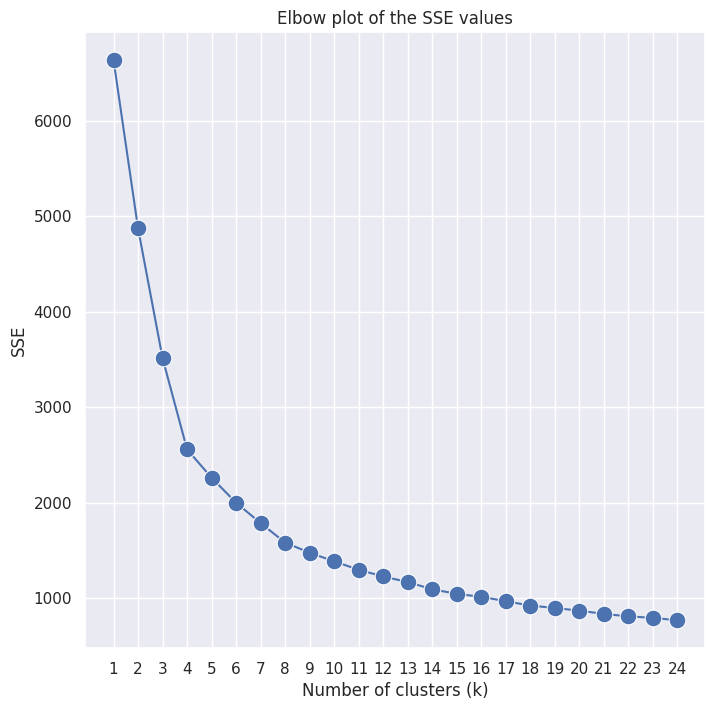

In [ ]:
# Choose number of clusters using te Elbow Method
sse = [] # Within-cluster sum of squares
k_values = range(1, 25)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=744, n_init=10)
    km.fit(pca_3_scores_standardized)
    sse.append(km.inertia_)

plt.figure(figsize=(8, 8)) # Plot the elbow plot
plt.title('Elbow plot of the SSE values')
plt.ylabel('SSE')
plt.xlabel('Number of clusters (k)')

sns.lineplot(
    x=list(k_values),
    y=sse,
    marker='o',
    markersize=12,
)
plt.xticks(list(k_values))
plt.show()

> The elbow plot suggests a noticeable bend at K = 4, though K = 5 or 7 could also be reasonable choices. Following Occam’s Razor, we select K = 4 for its simplicity and interpretability.

Next, we will be fitting the K-Means with 4 clusters and assigned each customer a cluster label based on their PCA-transformed scores.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=742, n_init = 10)  # Fit Kmeans with 4 clusters
clusters = kmeans.fit_predict(pca_3_scores_standardized) + 1 # Assign a cluster label to each row, shift to 1-based index
pca_3_scores_standardized['Cluster'] = clusters # Add cluster labels back to the PCA dataframe
pca_3_scores_standardized.groupby('Cluster').mean(numeric_only=True).round(2) # View average standardized PC scores per cluster


,PC1,PC2,PC3
Cluster,,,
1,0.17,1.18,0.69
2,1.44,-0.56,-0.23
3,-0.74,-0.96,0.54
4,-0.62,0.41,-0.92


**Cluster Summaries:**

The analysis identified four distinct customer segments based on principal component scores. **Cluster 1**, the Socially Engaged, Lifestyle-Oriented Shoppers, is characterized by high PC2 and moderately positive PC1 and PC3 scores, indicating strong alignment with lifestyle, social, and digital behavior. These customers are trend-driven and highly engaged across channels, often influenced by brand aesthetics and peer behavior. **Cluster 2**, the Premium High-Value Customers, shows very high PC1 and slightly negative PC2 and PC3 scores, representing loyal and affluent customers who exhibit consistent, high-volume spending across core product categories. **Cluster 3**, labeled as Detached Bargain Seekers, displays negative PC1 and PC2 but a positive PC3 score, suggesting low engagement and limited spending behavior, with occasional responsiveness to digital interactions or promotions. Lastly, **Cluster 4**, the Infrequent, Selective Buyers, is defined by negative PC1 and PC3 with mildly positive PC2, reflecting irregular purchase behavior and weak brand attachment, though with some alignment to specific marketing messages or seasonal trends.

> To visualize the separation of clusters, we plotted customers along the first two principal components. This 2D projection retains the majority of the variance and is easier to interpret than a 3D plot.

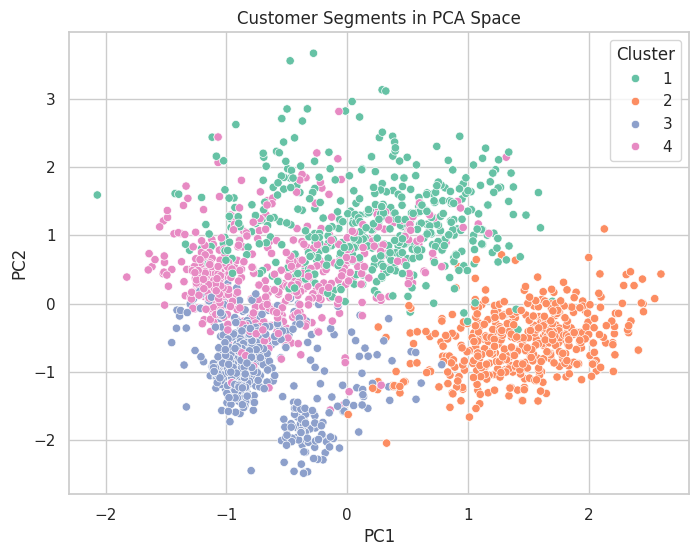

In [ ]:
sns.set(style="whitegrid") # plot 2D plots using PC1 and PC2
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette='Set2',
    data=pca_3_scores_standardized
)
plt.title('Customer Segments in PCA Space')
plt.show()


> Although clustering was done on PCA-reduced features, we now attach the cluster labels back to the **original dataset** to extract actionable insights about customer behavior.

In [ ]:
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = clusters # Add cluster labels to the original data

# Check average values by cluster
cluster_profiles = data_with_clusters.groupby('Cluster').mean(numeric_only=True).round(2) # Group data by cluster and calculate the mean of each variable for each cluster
cluster_profiles


,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp2,Complain,Response,Tenure_Days,Age,Living_With,Children,Family_Size,Is_Parent,Spent
Cluster,,,,,,,,,,,,,,,,,,,,,
1,1.26,58461.74,0.36,0.92,49.79,493.73,33.50,175.60,45.58,36.39,...,0.02,0.01,0.17,492.72,57.91,0.65,1.28,1.94,0.99,860.05
2,1.31,75791.93,0.01,0.01,49.26,601.88,63.09,459.16,92.41,63.94,...,0.03,0.01,0.30,337.35,57.01,0.59,0.02,0.61,0.02,1352.91
3,0.98,29260.42,0.77,0.08,48.13,31.91,6.86,25.32,10.99,6.86,...,0.00,0.01,0.12,367.15,47.99,0.60,0.85,1.45,0.79,100.18
4,1.52,48770.67,0.55,0.98,49.03,165.74,8.71,55.27,11.44,8.17,...,0.00,0.01,0.04,236.54,61.66,0.73,1.53,2.26,0.99,268.08


> From this approach, we can now identify meaningful differences in income, age, household structure, and spending across customer segments.

* Customers in cluster 1 have an average income of $58,462, an average age of 57.9 years, and typically 1.28 children at home. They tend to live in slightly larger families (average family size 1.94), and nearly 99% are parents. Their average total spending is approximately \$860.

* Cluster 2 has the highest average income at $75,792, with an average age of 57.0 years. They rarely have children (0.02 children on average) and live in smaller households (0.61 average family size). Only 2% are parents, yet they have the highest average spending of around \$1,353.

* Customers in cluster 3 have a lower average income of $29,260, are younger (average age 48.0 years), and typically have 0.85 children. Family size is around 1.45, and about 79% are parents. Their average spending is the lowest at approximately \$100.

* Cluster 4 has a moderate income of $48,771 and is the oldest segment with an average age of 61.7 years. They tend to have 1.53 children and larger families (average family size 2.26). About 99% are parents, and their average spending is about \$268.

> We calculated the **silhouette score** to assess how well-defined the clusters are. A higher score (closer to 1) indicates better separation between clusters.

In [ ]:
score = silhouette_score(pca_3_scores_standardized.drop('Cluster', axis=1), clusters)
print("Silhouette Score:", round(score, 3))


Silhouette Score: 0.359


## Conclusion

Our customer segmentation using **PCA-reduced features** and **K-Means clustering** revealed four unique behavioral clusters that provide a structured lens through which managers can understand their customer base more strategically.

### **Managerial Insights:**

These clusters offer clear strategic value for marketing and customer engagement.
* **Cluster 1** presents a strong opportunity for influencer marketing, limited-edition product drops, and community-focused initiatives that emphasize brand lifestyle.
* **Cluster 2** should be prioritized through loyalty programs, exclusive offers, and retention strategies, as this segment contributes significantly to revenue and demonstrates consistent brand alignment.
* **Cluster 3** can be targeted with tactical promotional campaigns, discounts, and win-back strategies that appeal to their price sensitivity and low brand commitment.
* **Cluster 4**, while less consistent, can be nurtured through seasonal campaigns, curated product bundles, and reactivation reminders to encourage more frequent engagement. Overall, this segmentation framework supports refined targeting, efficient marketing spend, improved retention, and more personalized customer experiences.
>>



While the clustering approach yielded valuable customer insights, several limitations should be acknowledged:

### **Limitations:**

> **Assumption of Spherical Clusters in K-Means**
>> K-Means inherently assumes that clusters are spherical and evenly sized, which may not hold true for real-world customer data. If the underlying structure is more complex (e.g., overlapping or elongated clusters), K-Means may oversimplify and misclassify certain data points.

> **Moderate Silhouette Score (0.359)**
>> The silhouette score, while not poor, indicates only a moderate separation between clusters. This suggests that while patterns exist, they are not starkly distinct—possibly due to overlap in customer behaviors or limitations in the selected features.

> **Static Snapshot Without Temporal Dynamics**
>> This analysis uses static customer data without accounting for changes over time (e.g., shifts in behavior due to seasonality, promotions, or customer lifecycle). Clusters might evolve, and the current grouping may not remain valid in dynamic market conditions.

> **Potential Feature Bias in PCA and Clustering**
>> Even though features were standardized, any imbalance or underrepresentation in key behavioral variables could skew PCA weights and influence the clustering disproportionately, leading to biased groupings.

## Team cooperation

#### Challenges
1. Challenges in selecting the number of principal components:

>We observed conflicting recommendations from selection criteria — the elbow method suggested retaining 3 components, while Kaiser’s rule pointed to 6. Although the 6-component solution captured more variance overall, further examination revealed that components beyond PC3 offered limited managerial value. These additional components were driven by less actionable variables (e.g., family structure, web visit frequency) and diluted the interpretability of the segmentation. To balance simplicity and insight, we retained 3 components, which together explained approximately 56% of the total variance.

2. Challenge in selecting the clustering method:

> We tested both K-Means and Agglomerative Clustering (using the `Ward` linkage method) and found that both produced similar cluster structures and suggested the same number of clusters. To make the final selection, we compared their Silhouette Scores and chose the method with the higher score for better-defined segmentation.

#### Work distributes

> Our team maintained strong communication and collaboration throughout this assignment. We met as a group multiple times to discuss our approach for this project. Prior to our check-in with Professor Hao, we met as a group to decide which methods we would use to analyze the dataset. At this meeting, we also divided the work among our group members. Quinn worked on the introduction, Danfei and Leyun worked on the PCA and K-Means analysis, Victor and Simran worked on PCA and K-Means cluster interpretations. To wrap up, Danfei took the lead on the conclusions, and Daniel tackled team cooperation. Additionally, all team members helped edit and proofread one another’s sections to ensure consistent voice and accurate results.

> To finalize our project, our whole team met on Zoom to collaborate on assembling the final Colab file and making final edits to our text. Leyun took the lead in finalizing the Colab file to ensure consistent style throughout the notebook, while the rest of the group offered feedback and suggestions. All members of the group were present at each team Zoom meeting, completed work on time, and collaborated well together throughout the project.

